# Transfer Learning

You wouldn't train your models from scratch (with random initialization) when you're dealing with a large enough datasets because you probably don't have enough computing power or short on time. So you might ask, *"how can I train my models then?"*. Well, you can initialize your model with pretrained open source models like Inception, VGG, Residual Networks etc. and then replacing the final classification layer to fit *(no pun intended)* your dataset.

By doing this, you get a huge performance gain and of course you don't need so much computing power or time unlike training it from scratch. Now that I've got your appetite whet. Let's look at what we're going to learn today:

- Finetuning: Instead of training your model from scratch, we'll initialize it with a pretrained model. Rest of the training looks as usual.

- Feature extractor: Since, those models such as Inception has been trained on the imagenet dataset *(which has 1,000 classes)*, we expect the the models to have already learnt mappings for different image inputs. Therefore, we'll freeze the weight for all the network, except the final fully connected layer which is replaced with a new one (initialized random weights). We only train this last layer.

There are so much more we can do with transfer learning. Check out [cs231n notes](http://cs231n.github.io/transfer-learning/) for more information about transfer learning.

Without further a-do. Let's import our dependencies

In [1]:
# Built-in modules.
import os
import copy
import time

# Scientific libaries.
import numpy as np

# Machine learning.
import torch
import torch.nn as nn
import torch.optim as optim

from torch.autograd import Variable
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader

# Torch vision for loading models and datasets.
import torchvision
from torchvision import models, datasets, transforms

# Custom utility module.
from utils import *

In [2]:
# Dataset directory.
data_dir = '../datasets/hymenoptera'

# Get the training and validation phase. ['train', 'val']
phases = [f for f in os.listdir(data_dir) 
          if os.path.isdir(os.path.join(data_dir, f))]

# Normalization mean and standard deviation.
norm_mean = [0.5, 0.5, 0.5]  # [0.485, 0.456, 0.406]
norm_std = [0.5, 0.5, 0.5]   # [0.229, 0.224, 0.225]

# Device to load model/inputs. Uses GPU if it's available.
device = torch.device(
    "cuda:0" if torch.cuda.is_available() else "cpu"
)

# Training hyperparameters.
use_gpu = torch.cuda.is_available()
batch_size = 16     # mini-batch size.
lr = 1e-2           # learning rate.
momentum = 0.9      # learning rate decay momentum.
epochs = 15         # Number of times to loop over full batch.

In [3]:
# Data transformation rules.
data_transforms = {
    # Randomly crop and flip training images then
    # convert it to tensor and normalize.
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std)
    ]),
    # Resize, center crop image and convert it to tensor.
    # We also normalize the image like we did to training set.
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std)
    ]),
}

# Apply the transform rule and load the dataset from disk.
datasets = {phase: datasets.ImageFolder(os.path.join(data_dir, phase), 
                                        data_transforms[phase])
           for phase in phases}

# Data loaders to load our datasets into mini-batches.
loaders = {phase: DataLoader(datasets[phase], batch_size=batch_size, 
                             shuffle=True, num_workers=4)
          for phase in phases}

# Compute the size of each sets of data.
data_sizes = {phase: len(datasets[phase]) for phase in phases}

# Retrieve class names for images.
classes = datasets[phases[0]].classes

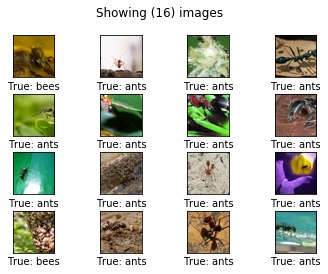

In [4]:
visualize(loaders[phases[0]], classes=classes, normalize=[norm_mean, norm_std])

### Training the Model

It's time to train our model. Unlike before, you don't need to define a subclass of the `nn.Module` class and implement the `forward` function. We can just download the use a pre-trained model and then train the final layer (as we talked about earlier).

Here, we'll perform something called **Early Stopping**. Early stopping is a technique used to prevent overfitting by stopping training if our model no longer performs better (give higher accuracy) on the validation set, usually over a set period of epochs or batches. We can optionally save the model at last recorded best accuracy (which is what we'll do). 

We'll also include a **scheduler**. A scheduler performs a taks or series of tasks in between epochs (usually after updating gradient). Schedulers are mostly used to adjust learning rate of each parameter group. We'll be using `optim.lr_scheduler.StepLR` to decay learning rate by a given factor after a set number of epochs.

Alright, let's define a `train_model` function to train, validate and perform early stopping.

In [ ]:
def train_model(model: nn.Module, criterion: any, optimizer: optim.Optimizer, 
                scheduler: optim.lr_scheduler, epochs: int=10):
    """Trains an existing model.
    
    Arguments:
        model {nn.Module}: Model to be trained.
        criterion {any}: Loss function.
        optimizer {optim.Optimizer}: Instance of optim.Optimizer
        scheduler {optim.lr_scheduler}: Learning rate scheduler.
    
    Keyword Arguments:
        epochs {int}: How many training epochs?
    
    Examples:
    ```python
    >>> # Using a pretrained model (18 layers Residual Network).
    >>> model_ft = models.resnet18(pretrained=True)
    >>> num_ftrs = model_ft.fc.in_features
    >>> model_ft.fc = nn.Linear(num_ftrs, 2)
    >>>
    >>> model_ft = model_ft.to("cuda" if torch.cuda.is_available() else "cpu")
    >>>
    >>> criterion = nn.CrossEntropyLoss()
    >>>
    >>> # Observe that all parameters are being optimized.
    >>> optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
    >>>
    >>> # Decay LR by a factor of 0.1 every 7 epochs.
    >>> exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
    >>>
    >>> # Train the model.
    >>> model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler)
    -------------------------------------------------------
    Epoch 1 of 10
        train loss = 0.00; acc = 12.74%
        val loss = 0.04; acc = 11.06%
    -------------------------------------------------------
    ...
    -------------------------------------------------------
    Epoch 10 of 10
        train loss = 0.02; acc = 96.22%
        val loss = 0.01; acc = 97.01%
    -------------------------------------------------------

    ```
    
        
    """
    # Start the training clock.
    start = time.time()
    
    # Save the best model weights and accuracy.
    best_model_weights = copy.deepcopy(model.state_dict())
    best_model_acc = 0.0
    
    # Running epoch accuracy.
    epoch_acc = 0.0
    
    # Start the training loop.
    for epoch in range(epochs):
        try:
            print(55 * '-')
            print('Epoch {:} of {:,}'.format(epoch+1, epochs))
            
            # Each epoch goes through training & validation phase.
            for phase in phases:
                # Set Model to training/evaluation mode.
                if phase == 'train':
                    scheduler.step()
                    model.train()
                else:
                    model.eval()
                
                # Running loss & accuracy.
                running_loss = 0.0
                running_acc = 0.0
                
                # Iterate over the mini-batch.
                for inputs, labels in loaders[phase]:
                    # Process inputs & labels in GPU if available.
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    
                    # Zero the optimizer gradient buffer.
                    optimizer.zero_grad()
                    
                    
                    
        except KeyboardInterrupt:
            print('\nTraining interrupted!')
            
            # Save the weights only if accuracy is better.
            if epoch_acc > best_model_acc:
                print('Saving model weights...')
                
                # Save model parameters.
                best_model_weights = copy.deepcopy(model.state_dict())
                
                # Update accuracy.
                best_model_acc = epoch_acc
                
                print('Model saved!')
            else:
                print('Not saved! Current model has a better accuracy.')
            
            # End training.
            break

In [5]:
def train_model(model, criterion, optimizer, scheduler, epochs=10):
    # Start the training clock.
    start = time.time()
    
    # Save the best model weights and accuracy.
    best_model_weights = copy.deepcopy(model.state_dict())
    best_model_acc = 0.0
     
    # Start the training loop.
    for epoch in range(epochs):
        
        try:

            print(55 * '-')
            print('Epoch {:,} of {:,}'.format(epoch+1, epochs))

            # Training and validation phase.
            for phase in phases:

                # Toggle training and validation mode.
                if phase.lower() == 'train':
                    scheduler.step()
                    model.train(True)   # Set model to training mode.
                else:
                    model.train(False)  # Set model to validation mode.

                # Running loss and accuracy.
                running_loss = 0.0
                running_acc = 0

                # Iterate over the data in mini-batches.
                for inputs, labels in loaders[phase]:
                    # Wrap inputs and labels in autograd.Variable.
                    # Load images on GPU if available, otherwise, use CPU.
                    if use_gpu:
                        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                    else:
                        inputs, labels = Variable(inputs), Variable(labels)

                    # Zero out the optimizer gradient buffer.
                    optimizer.zero_grad()

                    # Forward pass.
                    outputs = model(inputs)
                    _, pred = torch.max(outputs.data, dim=1)

                    # Compute the loss
                    loss = criterion(outputs, labels)

                    # Perform backward pass only during training.
                    if phase.lower() == 'train':
                        # Back propagate.
                        loss.backward()

                        # Update weights.
                        optimizer.step()

                    # Compute the running loss & accuracy.
                    running_loss = loss.data[0] * inputs.size(0)
                    running_acc = torch.sum(pred == labels.data)

                    # !- End mini-batch.

                # Calculate the loss and accuracy for current epoch.
                epoch_loss = running_loss / data_sizes[phase]
                epoch_acc = running_acc / data_sizes[phase]

                print('\t{} loss = {:.2f}; acc = {:.2%}'.format(phase, epoch_loss, epoch_acc))

                # Save the best model with high accuracy.
                if phase.lower() == 'val' and epoch_acc > best_model_acc:
                    # Save the model parameters.
                    best_model_weights = copy.deepcopy(model.state_dict())

                    # Update the best accuracy.
                    best_model_acc = epoch_acc
            
            # Epoch divider.
            print(55 * '-', end='\n\n')
            
            # !- End epoch.
            
        except KeyboardInterrupt:
            print('\nIteration stopped! Saving model...')
            
            # Save the best model with high accuracy.
            if epoch_acc > best_model_acc:
                # Save the model parameters.
                best_model_weights = copy.deepcopy(model.state_dict())

                # Update the best accuracy.
                best_model_acc = epoch_acc
                
                print('Model saved!')

            # Break out of the loop! (IMPORTANT)
            break

    # !- Done Training.

    # Calculate end time.
    time_elapsed = time.time() - start

    print('Training completed in {:.0f}mins {:.0f}secs'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best validation accuracy: {}'.format(best_model_acc))

    # Load the best model.
    model.load_state_dict(best_model_weights)
    return model

In [6]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [7]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler)

-------------------------------------------------------
Epoch 1 of 10


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


	train loss = 0.01; acc = 0.00%
	val loss = 0.02; acc = 0.00%
-------------------------------------------------------

-------------------------------------------------------
Epoch 2 of 10
	train loss = 0.00; acc = 0.00%
	val loss = 0.04; acc = 0.00%
-------------------------------------------------------

-------------------------------------------------------
Epoch 3 of 10
	train loss = 0.02; acc = 0.00%
	val loss = 0.01; acc = 0.00%
-------------------------------------------------------

-------------------------------------------------------
Epoch 4 of 10
	train loss = 0.00; acc = 0.00%
	val loss = 0.02; acc = 0.00%
-------------------------------------------------------

-------------------------------------------------------
Epoch 5 of 10
	train loss = 0.00; acc = 0.00%
	val loss = 0.01; acc = 0.00%
-------------------------------------------------------

-------------------------------------------------------
Epoch 6 of 10
	train loss = 0.00; acc = 0.00%
	val loss = 0.00; acc =